In [1]:
import sys

sys.path.append(
    "/home/sayem/Desktop/deepHSI"
)  # Replace this with the actual path to your project root

from pathlib import Path

import numpy as np

# Now you should be able to import your custom modules
from src.dataset.components.hyperspectral_dataset import HyperspectralDataset
from src.dataset.components.utils import *

In [2]:
dataset_name = "KSC"
data_dir = Path("/home/sayem/Desktop/deepHSI/data")
target_folder = data_dir / dataset_name
target_folder.mkdir(parents=True, exist_ok=True)

# Ensure the dataset is downloaded only once for the session
download_dataset(dataset_name, str(target_folder))

# Load the dataset components
img, gt, label_values, ignored_labels, rgb_bands, _ = load_dataset(
    dataset_name, str(target_folder)
)

hyperparams = {
    "dataset": dataset_name,
    "patch_size": 4,
    "ignored_labels": ignored_labels,
    "center_pixel": True,
    "supervision": "full",
}

dataset = HyperspectralDataset(img, gt, transform=None, **hyperparams)

In [3]:
img.shape

(512, 614, 176)

In [4]:
image, label = dataset[0]

In [5]:
image.shape

torch.Size([1, 176, 4, 4])

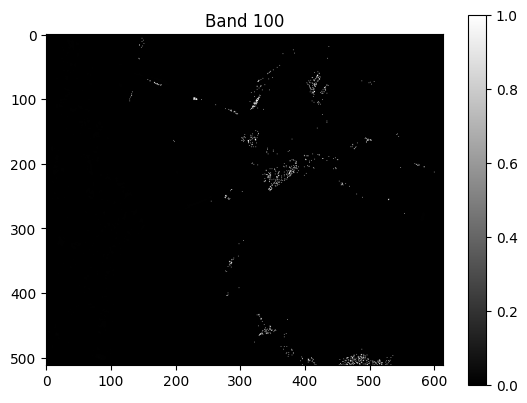

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `img` is your 3D image array with shape (512, 217, 204)

# Correcting the assumption about the array dimensions:
# img.shape = (samples, lines, bands)

# Selecting the 100th band from the image
# Given the structure, the band data is still the third dimension
band_to_plot = img[:, :, 99]  # 99 for the 100th band as indexing starts from 0

# Plotting the selected band
plt.imshow(band_to_plot, cmap='gray')  # Using 'gray' colormap for the band image
plt.colorbar()  # Adds a colorbar to represent the intensity scale of the band
plt.title('Band 100')  # Setting the title to indicate the band being plotted
plt.show()  # Display the plot

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

# Assuming `img` is your 3D image array with shape (samples, lines, band
# Subfolder for PNG files
subfolder = 'bands'
os.makedirs(subfolder, exist_ok=True)  # Create the subfolder if it doesn't exist

for i in range(img.shape[2]):  # Loop through each band
    band_to_plot = img[:, :, i]
    
    # Plotting the selected band with a heatmap-like colormap
    plt.figure(figsize=(10, 4), dpi=200)
    plt.imshow(band_to_plot, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title(f'Band {i+1}')
    plt.axis('off')
    
    # Define the PNG filename within the subfolder
    png_filename = os.path.join(subfolder, f'{i+1}.png')
    
    # Save the plot as a PNG file in the subfolder
    plt.savefig(png_filename, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()

In [8]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `gt` is your 2D ground truth array with shape (512, 217)

# Creating a figure and axis for better control
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size for better clarity

# Creating a discrete colormap for your 16 classes
cmap = plt.get_cmap('tab20', 16)  # 'tab20' colormap with 16 distinct colors

# Plotting the ground truth array with the colormap
im = ax.imshow(gt, cmap=cmap, vmin=0, vmax=15)  # Ensure vmin and vmax match the range of your classes

# Creating a colorbar with a tick for each class
# Here, we specify the boundaries and ticks for clarity
cbar = fig.colorbar(im, ax=ax, boundaries=np.arange(-0.5, 16, 1), ticks=np.arange(0, 16), fraction=0.02, pad=0.04)
cbar.set_label('Class Labels')  # Labeling the color bar
cbar.set_ticklabels([f'Class {i}' for i in range(16)])  # Set custom tick labels

# Setting the title and axis labels for more informative presentation
ax.set_title('Ground Truth Visualization with 16 Classes')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Line Index')

plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming `img` is your 3D hyperspectral image array with shape (lines, samples, bands)

# Reshape the image to a 2D array (pixels, bands)
lines, samples, bands = img.shape
img_reshaped = img.reshape((lines * samples, bands))

# Initialize PCA, you can choose the number of components (n_components) based on your needs
# For demonstration, let's reduce the bands to 10 principal components
pca = PCA(n_components=10)

# Fit and transform the data to reduce dimensions
img_pca = pca.fit_transform(img_reshaped)

# Reshape the transformed data back to a 3D array (lines, samples, n_components)
img_pca_reshaped = img_pca.reshape((lines, samples, pca.n_components))

print(img_pca_reshaped.shape)

# Visualize the first principal component as an example
plt.imshow(img_pca_reshaped[:, :, 0], cmap='gray')
plt.colorbar()
plt.title('First Principal Component')
plt.show()

# You can now use img_pca_reshaped for further analysis or classification


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming `img` is your 3D hyperspectral image array with shape (lines, samples, bands)
# And assuming you have a corresponding label array `labels` with the shape (lines, samples)

# Reshape the image to a 2D array (pixels, bands)
lines, samples, bands = img.shape
img_reshaped = img.reshape((lines * samples, bands))

# Also, reshape the labels to a 1D array
labels_reshaped = gt.reshape((lines * samples,))

# Split the data and labels into training and testing sets
X_train, X_test, y_train, y_test \
    = train_test_split(img_reshaped, labels_reshaped, test_size=0.3, random_state=42)

# Create a pipeline that includes PCA and KNN classifier
pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'pca__n_components': [50, 100, 150],  # Number of principal components to try
    'knn__n_neighbors': [3, 5, 7]  # Number of neighbors for KNN
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')

# Use the best estimator to make predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy of the best estimator on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Fit PCA on the entire dataset with the best number of components
best_pca = PCA(n_components=grid_search.best_params_['pca__n_components'])
img_pca_full = best_pca.fit_transform(img_reshaped)

# Extract the first principal component
first_pc_full = img_pca_full[:, 0]

# Reshape the first principal component to the original spatial dimensions
first_pc_reshaped = first_pc_full.reshape(lines, samples)

# Visualize the first principal component
plt.imshow(first_pc_reshaped, cmap='gray')
plt.colorbar()
plt.title('First Principal Component with Best PCA')
plt.show()